In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")


Using device: cuda


In [22]:
# Cell 2: Data Preprocessing with FER2013 Dataset
train_dir = '/kaggle/input/fer2013/train'
test_dir = '/kaggle/input/fer2013/test'

# Define transformations with data augmentation
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),  # Color augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize for FER2013 dataset
])

# Load the datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print class names
print("Classes:", train_dataset.classes)


Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


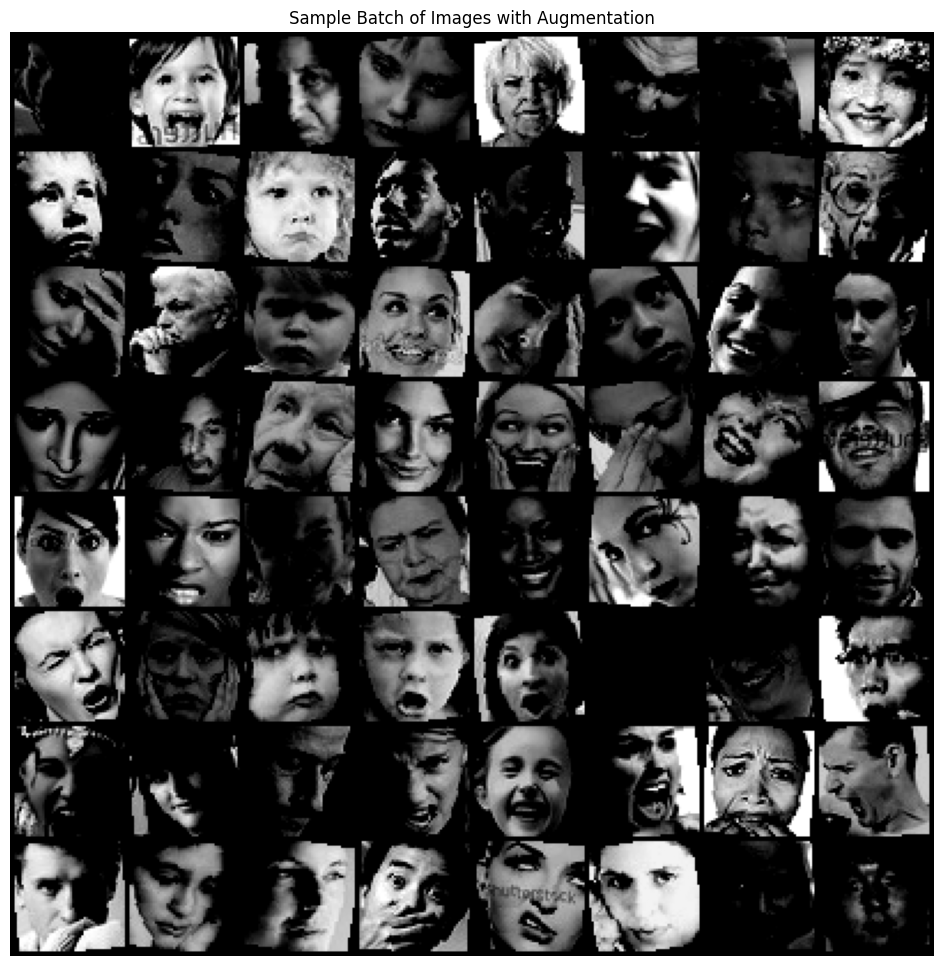

Labels: tensor([3, 3, 1, 5, 0, 0, 2, 3, 2, 6, 0, 4, 2, 3, 4, 6, 5, 0, 5, 3, 2, 0, 3, 5,
        5, 5, 4, 3, 6, 2, 3, 2, 6, 0, 0, 0, 3, 4, 5, 3, 0, 5, 0, 0, 6, 2, 3, 6,
        2, 4, 5, 0, 3, 0, 2, 0, 2, 2, 4, 6, 0, 4, 2, 4])


In [23]:
# Cell 3: Display a Batch of Images
batch = next(iter(train_loader))
images, labels = batch
to_plot = torchvision.utils.make_grid(images, nrow=8)
plt.figure(figsize=(12, 12))
plt.imshow(np.transpose(to_plot, (1, 2, 0)))
plt.title("Sample Batch of Images with Augmentation")
plt.axis('off')
plt.show()
print("Labels:", labels)


In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F  # Import F for functional API

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, stride=1)
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1)
        self.dropout1 = nn.Dropout(0.25)
        self.conv3 = nn.Conv2d(64, 128, 3, stride=1)
        self.conv4 = nn.Conv2d(128, 256, 3, stride=1)
        self.dropout2 = nn.Dropout(0.25)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Calculate the output size after convolutions
        self.flattened_size = self._get_conv_output_size((3, 48, 48))  # Input size should match the input image size
        
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 7)  # 7 classes for FER2013 emotions

    def _get_conv_output_size(self, shape):
        """Helper function to calculate the output size after the convolutional layers."""
        with torch.no_grad():
            input_tensor = torch.zeros(1, *shape)  # Batch size of 1
            output = self.pool(F.relu(self.conv1(input_tensor)))
            output = self.pool(F.relu(self.conv2(output)))
            output = self.pool(F.relu(self.conv3(output)))
            output = self.pool(F.relu(self.conv4(output)))
            return output.numel()  # Get the total number of elements in the tensor

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MyModel().to(device)


In [25]:
# Cell 5: Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import matplotlib.pyplot as plt

# Cell 7: Training Loop
num_epochs = 15
train_losses = []  # To store loss for each epoch

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    
    for inputs, labels in train_loader:  # Assuming train_loader is defined
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the appropriate device
        
        optimizer.zero_grad()  # Zero the gradients

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  

        running_loss += loss.item()  

    #  average loss for this epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)  # Store loss for plotting
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    # Plotting the training loss after each epoch
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.title('Training Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    

#  after training
plt.show()
print('Training Finished!')


Epoch [1/15], Loss: 1.7741
Epoch [2/15], Loss: 1.5450
Epoch [3/15], Loss: 1.3927
Epoch [4/15], Loss: 1.3106
Epoch [5/15], Loss: 1.2596
Epoch [6/15], Loss: 1.2276
Epoch [7/15], Loss: 1.2007
Epoch [8/15], Loss: 1.1798
Epoch [9/15], Loss: 1.1543
Epoch [10/15], Loss: 1.1359
Epoch [11/15], Loss: 1.1253
Epoch [12/15], Loss: 1.1127


In [ ]:
# Evaluation
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Accuracy: {accuracy:.2f}%")